In [280]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Attention, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [281]:
data = pd.read_csv("all_daily_max_temp.csv")  # Replace with your file name
features = ['elevation', 'relh', 'drct', 'sknt', 'alti', 'vsby', 'dewpoint_c', 'feel_c']
target = 'temp_c'
data=data.drop(columns=['Unnamed: 0','is_hot_day'])
data

,elevation,relh,drct,sknt,alti,vsby,temp_c,dewpoint_c,feel_c
0,74,41.42,200.0,4.0,30.060,6.21,25.0,11.0,25.000000
1,74,33.85,230.0,11.0,30.000,1.86,25.0,8.0,24.438889
2,74,53.03,280.0,4.0,30.030,6.21,22.0,12.0,22.000000
3,74,59.97,280.0,5.0,30.090,6.21,20.0,12.0,20.000000
4,74,49.37,40.0,11.0,30.090,6.21,21.0,10.0,21.000000
...,...,...,...,...,...,...,...,...,...
5402,74,41.19,330.0,8.0,29.925,6.21,29.0,14.5,28.719444
5403,74,42.52,10.0,7.0,29.880,6.21,29.0,15.0,28.844444
5404,74,39.58,30.0,9.0,29.970,6.21,28.0,13.0,27.638889
5405,74,34.69,40.0,18.0,30.060,6.21,28.0,11.0,27.333333


In [282]:
import numpy as np

# Alternative function to create sequences using sliding windows
def create_sequences_alternative(data, target_col, window_size, prediction_horizon):
    X, y = [], []
    
    # Iterate over the dataset using a sliding window
    for i in range(len(data) - window_size - prediction_horizon + 1):
        # Extract the feature values for the past 'window_size' time steps
        X_seq = data.iloc[i:i + window_size][features].values
        
        # Extract the target values for the next 'prediction_horizon' time steps
        y_seq = data.iloc[i + window_size:i + window_size + prediction_horizon][target_col].values
        
        # Append the sequences to the list
        X.append(X_seq)
        y.append(y_seq)
    
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    return X, y

# Parameters
window_size = 3  # Number of timesteps to look at for each sequence
prediction_horizon = 1  # Predict the next 3 days

# Create input-output pairs using the alternative method
X,y= create_sequences_alternative(data, target, window_size, prediction_horizon)

# Display the shapes of the data to check
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print(f"X train ,test shape: {X_train.shape, X_test.shape}")
print(f"y train ,test shape: {y_train.shape, y_test.shape}")


X shape: (5404, 3, 8)
y shape: (5404, 1)
X train ,test shape: ((4323, 3, 8), (1081, 3, 8))
y train ,test shape: ((4323, 1), (1081, 1))


In [283]:
def build_woa_cnn_att_lstm(input_shape):
    inputs = Input(shape=input_shape)

    # CNN Layer
    x = Conv1D(filters=20, kernel_size=16, activation='relu', padding='same')(inputs)

    # LSTM Layer
    lstm_out = LSTM(units=64, return_sequences=True)(x)

    # Attention Mechanism
    attention = Attention()([lstm_out, lstm_out])
    attention_out = Flatten()(attention)

    # Fully Connected Layer
    dense = Dense(64, activation='relu')(attention_out)
    dense = Dropout(0.2)(dense)

    # Output Layer
    outputs = Dense(1)(dense)

    # Compile Model
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.0082), loss='mse', metrics=['mae'])
    return model


In [284]:
# Build the model
model = build_woa_cnn_att_lstm(input_shape=(window_size, len(features)))

# Train the model
history = model.fit(X_train, y_train, 
                    epochs=20, 
                    batch_size=32, 
                    validation_data=(X_test, y_test))


Epoch 1/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 143.0036 - mae: 8.7389 - val_loss: 7.7530 - val_mae: 2.1087
Epoch 2/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17.0914 - mae: 3.2126 - val_loss: 7.0822 - val_mae: 2.0634
Epoch 3/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.1134 - mae: 3.0232 - val_loss: 10.9516 - val_mae: 2.6058
Epoch 4/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16.7223 - mae: 3.1534 - val_loss: 6.8655 - val_mae: 1.9956
Epoch 5/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14.5005 - mae: 2.9560 - val_loss: 6.5121 - val_mae: 1.9894
Epoch 6/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14.0148 - mae: 2.9251 - val_loss: 8.4422 - val_mae: 2.2877
Epoch 7/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14.3199 - mae: 2.9279 - val_loss: 8.2964 - val_mae: 2.2012
Epoch 8/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.9252 - mae: 2.9348 - val_loss: 13.4478 - val_mae: 2.9997
Epoch 9/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3m

In [285]:
# Predict the next temperature
next_temp = model.predict(X_test[-1].reshape(1, window_size, len(features)))
print(f"Predicted Next Temperature: {next_temp}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Predicted Next Temperature: [[27.657907]]


In [286]:
# Evaluate the model on training data
train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)

# Evaluate the model on test data
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

# Print the results
print(f"Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}")
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")


Train Loss: 6.5804, Train MAE: 1.8851
Test Loss: 5.6151, Test MAE: 1.7974


In [287]:
from sklearn.metrics import r2_score

# Predict values for the test set
y_pred = model.predict(X_test)

# Compute R²
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2}")


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
R²: 0.8769331110535677


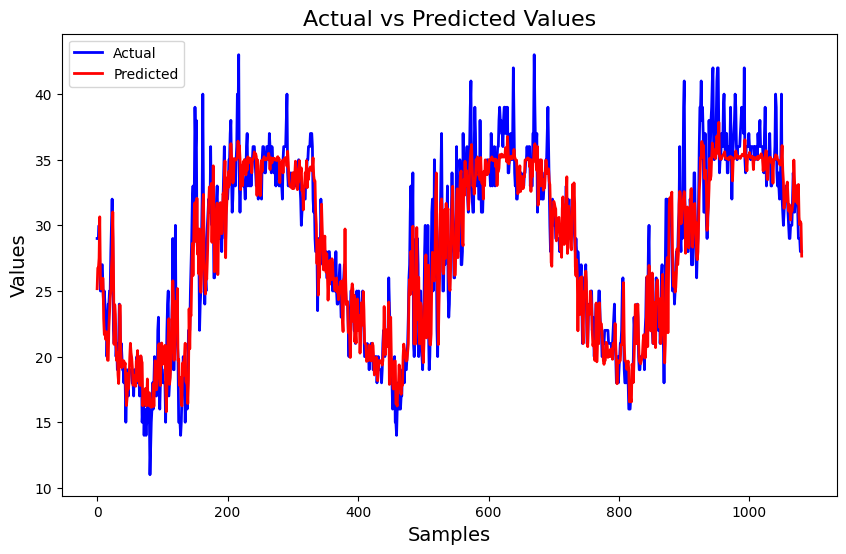

In [288]:
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are already defined
plt.figure(figsize=(10, 6))

# Plot the actual values
plt.plot(y_test, label='Actual', color='blue', linewidth=2)

# Plot the predicted values
plt.plot(y_pred, label='Predicted', color='red', linewidth=2)

# Adding title and labels
plt.title('Actual vs Predicted Values', fontsize=16)
plt.xlabel('Samples', fontsize=14)
plt.ylabel('Values', fontsize=14)

# Adding a legend
plt.legend()

# Display the plot
plt.show()

In [289]:
def build_lstm(input_shape):
    inputs = Input(shape=input_shape)

    # LSTM Layer
    lstm_out = LSTM(units=64)(inputs)

    # Fully Connected Layer
    dense = Dense(64, activation='relu')(lstm_out)
    dense = Dropout(0.2)(dense)

    # Output Layer
    outputs = Dense(1)(dense)

    # Compile Model
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.0082), loss='mse', metrics=['mae'])
    return model


In [296]:
lstm_model = build_lstm(input_shape=(window_size, len(features)))
lstm_history = lstm_model.fit(X_train, y_train, 
                              epochs=20, 
                              batch_size=32, 
                              validation_data=(X_test, y_test))

Epoch 1/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 154.8984 - mae: 9.2041 - val_loss: 9.9661 - val_mae: 2.5052
Epoch 2/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15.4744 - mae: 3.0864 - val_loss: 7.8682 - val_mae: 2.2187
Epoch 3/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15.2398 - mae: 3.0172 - val_loss: 8.2534 - val_mae: 2.2584
Epoch 4/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14.6915 - mae: 3.0315 - val_loss: 7.6462 - val_mae: 2.1392
Epoch 5/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12.5498 - mae: 2.7591 - val_loss: 8.3596 - val_mae: 2.2277
Epoch 6/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13.8402 - mae: 2.8839 - val_loss: 7.4855 - val_mae: 2.1200
Epoch 7/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15.1236 - mae: 3.0221 - val_loss: 8.9118 - val_mae: 2.3329
Epoch 8/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14.6681 - mae: 2.9762 - val_loss: 7.8905 - val_mae: 2.2246
Epoch 9/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/

In [297]:
# Predict the next temperature using LSTM
next_temp_lstm = lstm_model.predict(X_test[-1].reshape(1, window_size, len(features)))
print(f"LSTM Predicted Next Temperature: {next_temp_lstm} °C")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
LSTM Predicted Next Temperature: [[27.652945]] °C


In [298]:
# Evaluate both models
lstm_train_loss, lstm_train_mae = lstm_model.evaluate(X_train, y_train, verbose=0)
lstm_test_loss, lstm_test_mae = lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"Train Loss: {lstm_train_loss:.4f}, Train MAE: {lstm_train_mae:.4f}")
print(f"Test Loss: {lstm_test_loss:.4f}, Test MAE: {lstm_test_mae:.4f}")

Train Loss: 9.8694, Train MAE: 2.4625
Test Loss: 8.4729, Test MAE: 2.3264


In [299]:
# Compute R² for LSTM
from sklearn.metrics import r2_score

lstm_y_pred = lstm_model.predict(X_test)
lstm_r2 = r2_score(y_test, lstm_y_pred)

print(f"LSTM R²: {lstm_r2}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
LSTM R²: 0.8142987671922489


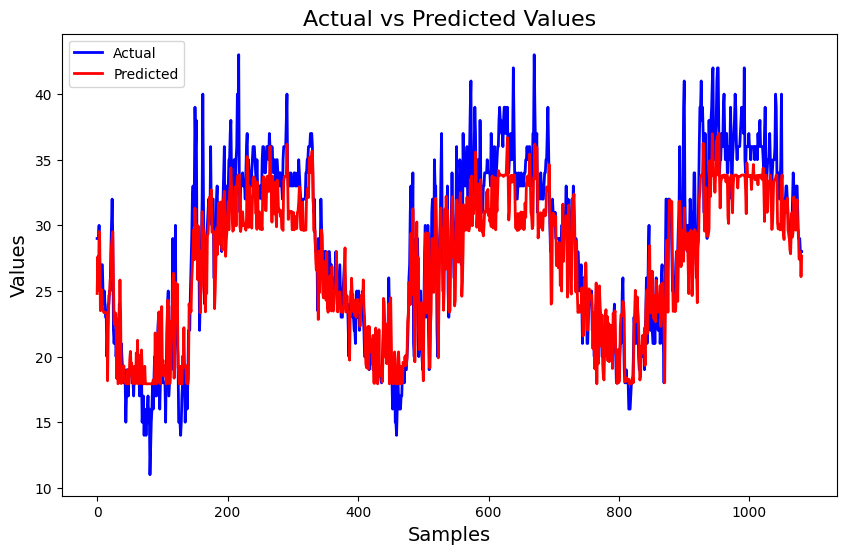

In [300]:
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are already defined
plt.figure(figsize=(10, 6))

# Plot the actual values
plt.plot(y_test, label='Actual', color='blue', linewidth=2)

# Plot the predicted values
plt.plot(lstm_y_pred, label='Predicted', color='red', linewidth=2)

# Adding title and labels
plt.title('Actual vs Predicted Values', fontsize=16)
plt.xlabel('Samples', fontsize=14)
plt.ylabel('Values', fontsize=14)

# Adding a legend
plt.legend()

# Display the plot
plt.show()